## Overview

This notebook performs sentiment analysis on twitter dataset obtained from Kaggle

Link to dataset: https://www.kaggle.com/c/twitter-sentiment-analysis2/data

- <a href="#section1"> Section 1: Exploring the training dataset </a>
- <a href="#section2"> Section 2: Test data </a>
- <a href="#section3"> Section 3: Pre-Processing data for Sentiment Analysis</a>
- <a href="#section4"> Section 4: Training and Evaluation </a>
- <a href="#section5"> Section 5: Metrics, Measurements and Conclusion </a>



<a id="section1"/>

## Section1: Exploring the training dataset

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import re
import string

from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [17]:
train_file = 'data/train.csv'
test_file = 'data/test.csv'

#Explore the training dataset
#Note: For some reason, if you dont specify the encoding as latin-1, the interpreter will throw an UTF-8 encoding error
data = pd.read_csv(train_file, error_bad_lines=False, encoding='latin-1')
data.columns = ['id', 'sentiment', 'text']
data.head(2)

,id,sentiment,text
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...


In [18]:
#Id information is not useful. So let's remove it
#axis=1 indicates columns
data = data.drop(labels=['id'], axis=1)
data.head(10)

,sentiment,text
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
5,0,or i just worry too much?
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,0,Sunny Again Work Tomorrow :-| ...
8,1,handed in my uniform today . i miss you ...
9,1,hmmmm.... i wonder how she my number @-)


### Observations:
1. Data has a mix of alphabets, numbers and symbols
2. Mix of words with uppercase and lowercase letters
3. We need to normalize the words to their base word. Leaving capitalizaed words in the middle of the tweet can be
   experimented with as they may hold different feature space like name of the person, country, etc.. 
4. No particular order of sentiment and tweets. If data is not randomly distributed then it can introduce bias to a learning model
5. Need to split and shuffle the data to reduce variance (makes sure the model can generalize better on the data) 
   and does not lead to overfitting 
6. Need to get an idea of the distribution of data

In [20]:
# calculate the number of positive and negative tweets
positives = data['sentiment'][data.sentiment == 1]
negatives = data['sentiment'][data.sentiment == 0]

print('Number of postive tweets {}' .format(len(positives)))
print('Number of negative tweets {}' .format(len(negatives)))
print('Total Length of the data is: {}' .format(data.shape[0]))

Number of postive tweets 56457
Number of negative tweets 43532
Total Length of the data is: 99989


### More observations
7. From the result, looks like an even distribution of positive and negative sentiments
8. Are there any duplicates in the data? Get the unique counts to identify this
9. How many average number of words are there in a tweet? Do a word count
10. What are the most common words present in the dataset?

In [21]:
data.groupby('sentiment').describe()

text                                                 
           count unique                                  top freq
sentiment                                                        
0          43532  43532               @cincindypat miss you     1
1          56457  56457  @banolka excellent m8,like it dude     1

Seems like there are no duplicates

In [22]:
# Function to calculate the number of words in a sentence.
# Using the delimiter to be a space
def word_count(tweet):
    return len(tweet.split())

data['word_count'] = data['text'].apply(word_count)
data.head(5)

,sentiment,text,word_count
0,0,is so sad for my APL frie...,7
1,0,I missed the New Moon trail...,6
2,1,omg its already 7:30 :O,5
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,25
4,0,i think mi bf is cheating on me!!! ...,9


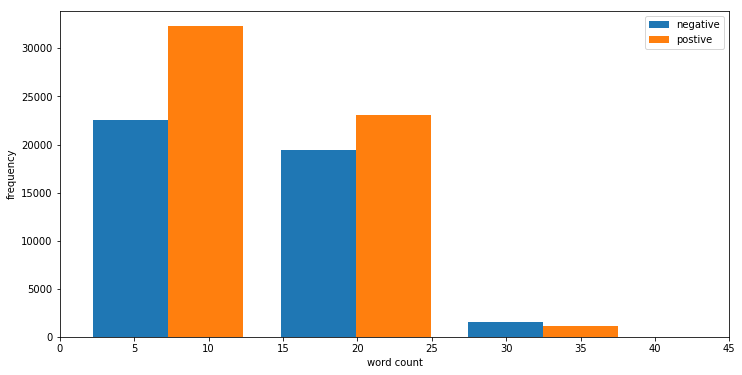

In [23]:
# Plot a histogram of the word counts

x = data['word_count'][data.sentiment == 0]
y = data['word_count'][data.sentiment == 1]
plt.figure(figsize=(12,6))
plt.xlabel('word count')
plt.ylabel('frequency')
graph = plt.hist([x,y], label=['negative', 'postive'])
plt.xlim(0,45)
plt.legend(loc='upper right')

### More observations

- From the histogram, it seems like most data seems to be less than 25 words. This is mostly because the tweet is less than 280 characters and so this data is good representative for twitter data
- Majority of them in the range of 5 to 10. 
- As the word count increases, the tweets tend to be negative
- There are more postive sentences/tweets which are 10 words an less


In [25]:
# Collect all the words in the training dataset
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

Counter(all_words).most_common(15)

[('i', 48880),
 ('the', 29629),
 ('to', 29177),
 ('you', 23456),
 ('a', 21908),
 ('and', 15826),
 ('it', 14154),
 ('my', 13598),
 ('for', 12378),
 ('is', 11618),
 ('in', 11497),
 ('of', 10519),
 ('that', 10051),
 ('have', 9794),
 ('on', 9228)]

- This shows the top 15 common words in the training dataset
- From the list, the stop words like **the**, **to** etc.. are very highly used. They are generally used in both positive and negative expressions and hence do not add any information that can be incorporated into the model. So these words can be removed from the data set

###  Frequency Distribution
Frequency distribution = frequency of each vocabulary item in the text

It is a distribution because it tells us how the total number of word tokens in the text are distributed across the vocabulary items. 

Reference: https://www.nltk.org/book/ch01.html

<FreqDist with 165473 samples and 1330178 outcomes>


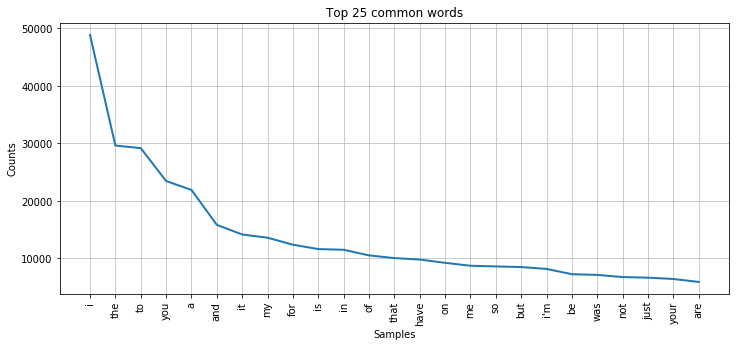

In [26]:
# plot word frequency distribution of top common words
plt.figure(figsize=(12,5))
plt.title("Top 25 common words")
fd = nltk.FreqDist(all_words)
print(fd)
fd.most_common(25)
fd.plot(25, cumulative=False)

### Log-Log Plot

Both dimensions are in logarithmic scale.

Reasons to construct a log log plot:

1. To respond to skewness towards large values; i.e., cases in which one or a few points are much larger than the bulk of the data.
2. To show percent change or multiplicative factors.

Text(0.5,1,"Log-Log Plot of words' frequency")

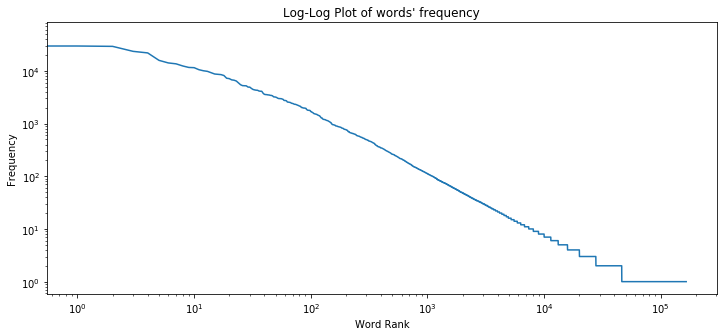

In [27]:
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts)
plt.xlabel("Word Rank")
plt.ylabel("Frequency")
plt.title("Log-Log Plot of words' frequency")

The log-log plot for the words frequency and word rank. It is for the entire training dataset. 

- Seems like the frequency drops as the rank decreases (Note: As far as word rank goes, higher the number lower the rank)
- Need to check if this still holds true after removing the stop words

<a id="section2"/>

### Section 2: Test Data

In [28]:
test_data=pd.read_csv(test_file, error_bad_lines=False, encoding='latin-1')
test_data.head(2)

,ItemID,SentimentText
0,1,is so sad for my APL frie...
1,2,I missed the New Moon trail...


In [29]:
#Id information is not useful
test_data=test_data.drop(labels=['ItemID'], axis=1)
test_data.head(5)

,SentimentText
0,is so sad for my APL frie...
1,I missed the New Moon trail...
2,omg its already 7:30 :O
3,.. Omgaga. Im sooo im gunna CRy. I'...
4,i think mi bf is cheating on me!!! ...


<a id="section3"/>

### Section 3: Pre-Processing data for Sentiment Analysis

Text pre-processing is an important step in a Natural Language Processing (NLP) task because it helps remove any unnecessary characteristics in the data which would make the final trained model a poor generalizer

What is involved in the pre-processing?

- Removing unwanted characters like punctuations, emojis, etc...
- Properly formatting the text to remove extra spaces or any other information in that text
- Removing stop words, common words that do not add any useful information 
- Need to make sure that the information we pass the model is in the format that a machine can understand (as binary/digits)
- Pre-Processing is done on the training data to facilitate the model's learning 

After pre-processing step, data should be fed to an appropriate machine learning algorithm to extract valuable information to do classification on new (unseen) data 

#### Pre-processing Step 1

Clean the tweet data by removing any hyperlinks and special characters

In [37]:
#Function to clean the tweets
def processText(text):
    #Convert to lowercase
    text = text.lower()    
    #Remove hyperlinks
    text = re.sub(r'http?:\/\/.*\/\w*', '', text)
    #Remove symbols, punctuations and replace with a space
    text = re.sub(r'[@!,;:)()_|]+', ' ', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    #Remove single space remaining at the front of the text
    text = text.lstrip(' ')
    return text

In [38]:
data['preprocessed'] = data['text'].apply(processText)
data.head(10)

,sentiment,text,word_count,preprocessed
0,0,is so sad for my APL frie...,7,is so sad for my apl friend.............
1,0,I missed the New Moon trail...,6,i missed the new moon trailer...
2,1,omg its already 7:30 :O,5,omg its already 7 30 o
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,25,.. omgaga. im sooo im gunna cry. i've been at ...
4,0,i think mi bf is cheating on me!!! ...,9,i think mi bf is cheating on me t t
5,0,or i just worry too much?,6,or i just worry too much?
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,2,juuuuuuuuuuuuuuuuussssst chillin
7,0,Sunny Again Work Tomorrow :-| ...,7,sunny again work tomorrow - tv tonight
8,1,handed in my uniform today . i miss you ...,10,handed in my uniform today . i miss you already
9,1,hmmmm.... i wonder how she my number @-),8,hmmmm.... i wonder how she my number -


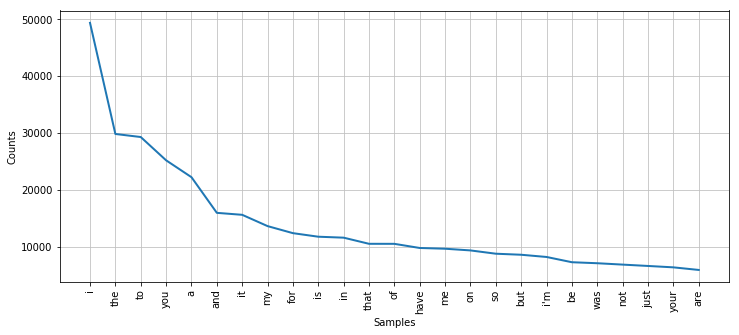

Text(0,0.5,'Frequency')

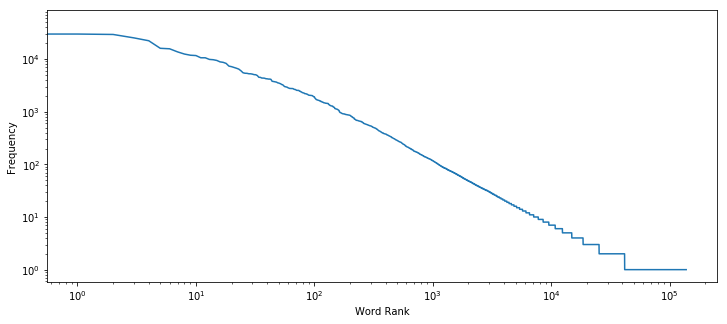

In [42]:
#Most common words in twitter dataset
all_words = []
for line in list(data['preprocessed']):
    words = line.split()
    for word in words:
        all_words.append(word)

# plot word frequency distribution of top 25
plt.figure(figsize=(12,5))
fd = nltk.FreqDist(all_words)
fd.plot(25, cumulative=False)
  
word_counts = sorted(Counter(all_words).values(), reverse=True)

#log-log of all words
plt.figure(figsize=(12,5))
plt.loglog(word_counts)
plt.xlabel("Word Rank")
plt.ylabel("Frequency")


In [43]:
#drop duplicates
data.shape

(99989, 4)

In [45]:
data = data.drop_duplicates('text')
data.shape

(99989, 4)

#### Preprocessing Step2: Tokenize without the stop words

The training data has not been transformed/preprocessed into a much cleaner set for feature extraction. 
There are some words in the dataset that are common in natural human language but used in all sentiment expressions that would be better off without them since they bring no useful features to our modele
These words are called "Stop words" in NLP and NLTK library comes with a dataset containing a long list of stop words that can be accessed and used to filter out of our dataset. The stop_words list can be customized depending on the dataset that we are working on - say legal documents or annual reports, then we need to add jargons corresponding to that dataset.


In [49]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swsundar/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [53]:
# print out the stop words
stop_words = stopwords.words('english')
print(','.join(stop_words))

len(stop_words)

i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't


179

- There seems to be a total of 179 stop words in the nltk corpus
- Next step: Remove the stop words, split all the sentences in the dataset to get individual words (called tokens) which is basically a list of words contained in the newly preprocessed set

In [57]:
def text_process(raw_text):
    '''
    Take a string of text, then perform the following:
    1. Remove all punctuation
    2. Remove all stop words
    3. Returns a list of processed text
    '''
    nopunct = [char for char in list(raw_text) if char not in string.punctuation]
    nopunct = ''.join(nopunct)
    return [word for word in nopunct.lower().split()
               if word.lower() not in stop_words]

In [59]:
# tokenize the data and create a column for tokens
data_copy = data.copy()
data_copy['tokens'] = data['preprocessed'].apply(text_process)
data_copy.head()

,sentiment,text,word_count,preprocessed,tokens
0,0,is so sad for my APL frie...,7,is so sad for my apl friend.............,"[sad, apl, friend]"
1,0,I missed the New Moon trail...,6,i missed the new moon trailer...,"[missed, new, moon, trailer]"
2,1,omg its already 7:30 :O,5,omg its already 7 30 o,"[omg, already, 7, 30]"
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,25,.. omgaga. im sooo im gunna cry. i've been at ...,"[omgaga, im, sooo, im, gunna, cry, ive, dentis..."
4,0,i think mi bf is cheating on me!!! ...,9,i think mi bf is cheating on me t t,"[think, mi, bf, cheating]"


- Additional normalization techniques like stemming and lemmatization can be done. These may not be useful for twitter data because they are short my design and stemming and lemmatization shorten words to their base words

Resources:
- http://www.nltk.org/howto/stem.html
- http://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer

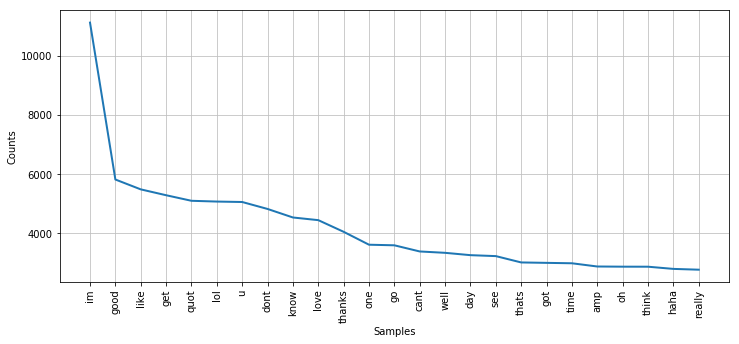

Text(0,0.5,'frequency')

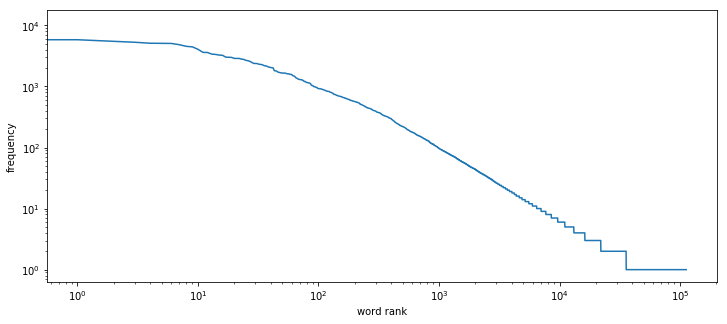

In [60]:
# now lets understand and explore the tokens further
all_tokens = []
for tokens in data_copy['tokens']:
    words = [w for w in tokens]
    for word in words:
        all_tokens.append(word)

#plot the word frequency distribution
plt.figure(figsize=(12,5))
fd = nltk.FreqDist(all_tokens)
fd.plot(25, cumulative=False)

word_counts = sorted(Counter(all_tokens).values(), reverse=True)

#plot the log log graph for all tokens
plt.figure(figsize=(12,5))
plt.loglog(word_counts)
plt.xlabel("word rank")
plt.ylabel("frequency")



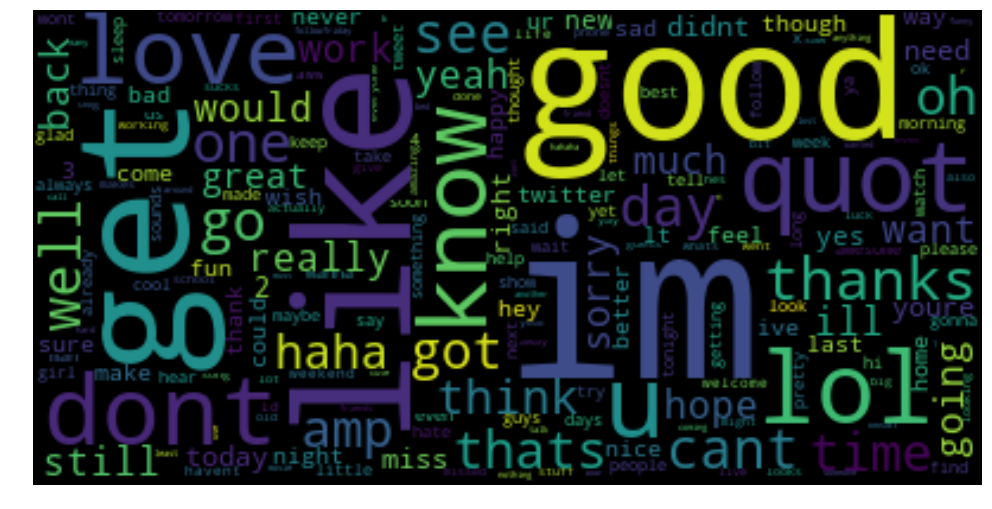

In [70]:
#building the word cloud
word_freq = Counter(all_tokens)

# to install the wordcloud run the command:
# conda install -c conda-forge wordcloud
word_cloud = WordCloud(normalize_plurals=True).generate_from_frequencies(word_freq)

plt.figure(figsize=(17,14))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Preprocessing Step 4: Feature Extraction

Now convert each set of tokens into a vector that a ML model can work on

##### Bag of Words

Bag of Words model is a 3 step process:

1. Count how many times a word occurs in each tweet (Term Frequency)
2. Weigh the counts such that the frequent words get lower weights (Inverse Document Frequency)
3. Normalize the vector to unit length to abstract from the original text (L2 Norm)

Notes:

- We will use the CountVectorizer from scikit-learn that converts the text documents into a matrix of count vector.
- Imagine it as a 2D matrix, where 1D is a vocabulary contained in the tweets and the other dimension is one column per tweet
- Since there are so many tweets and few words, then we can expect many zero counts for every word in the data. So we will use Sparse Matrix represntation

##### Resources:
1. Bag of Words: 
2. python scikit-learn:
3. Sparse Matrix:
4. Term Frequency:
5. Inverse Document Frequency:
6. To install sklearn:
       conda install scikit-learn 


In [77]:
#vectorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(data_copy['text'])

#total number of words in the vocabulary?
print(len(bow_transformer.vocabulary_))


99653


In [86]:
# vector representation
sample_tweet = data_copy['text'][1000]
print(sample_tweet)
print('\n')

bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

- Fwd: Good Morn,happy birthday !  regardless of what ppl said yesterday,they don't realize what happend behind the scene.One of the  ...


  (0, 84311)	1




In [87]:
# transform the entire DataFrame of tweets
tweets_bow = bow_transformer.transform(data_copy['text'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', tweets_bow.shape)
print('Amount of Non-Zero occurences: ', tweets_bow.nnz)


Shape of Sparse Matrix:  (99989, 99653)
Amount of Non-Zero occurences:  143879


##### Term Frequency and Inverse Document Frequency



In [ ]:
tfidf_transformer = TfidfTransformer.fit(tweets_bow)

